<a href="https://colab.research.google.com/github/derekschirripa/AERO_489_Machine_Learning/blob/main/AERO_489_Assignment3_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #training the network on my GPU to decrease runtime

In [2]:
import numpy as np


In [3]:
# We consider Net as our solution u_theta(t,x)

"""
When forming the network, we have to keep in mind the number of inputs and outputs
In ur case: #inputs = 2 (t,x)
and #outputs = 1

created a network with 10 hidden layers with 10 neurons each. The paper used 32 hidden layers, but they had a better GPU
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,10)
        self.hidden_layer2 = nn.Linear(10,10)
        self.hidden_layer3 = nn.Linear(10,10)
        self.hidden_layer4 = nn.Linear(10,10)
        self.hidden_layer5 = nn.Linear(10,10)
        self.hidden_layer6 = nn.Linear(10,10)
        self.hidden_layer7 = nn.Linear(10,10)
        self.hidden_layer8 = nn.Linear(10,10)
        self.hidden_layer9 = nn.Linear(10,10)
        self.hidden_layer10 = nn.Linear(10,10)
        self.output_layer = nn.Linear(10,1)

    def forward(self, t,x):
        inputs = torch.cat([t,x],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        layer5_out = torch.tanh(self.hidden_layer5(layer4_out))
        layer6_out = torch.tanh(self.hidden_layer6(layer5_out))
        layer7_out = torch.tanh(self.hidden_layer7(layer6_out))
        layer8_out = torch.tanh(self.hidden_layer8(layer7_out))
        layer9_out = torch.tanh(self.hidden_layer9(layer8_out))
        layer10_out = torch.tanh(self.hidden_layer10(layer9_out))
        output = self.output_layer(layer10_out) ## For regression, no activation is used in output layer
        return output

In [4]:
### (2) Model
net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters())

In [5]:
## PDE as loss function. Thus would use the network which we call as u_theta
def f(t,x, net):
    u = net(t,x) # the dependent variable u is given by the network based on independent variables x,t
    ## Based on our f = du/dt + udu/dx - nud2u/dx2, we need du/dx and du/dt
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    u_2x = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    nu = 0.01/np.pi
    pde = u_t + u*u_x - nu*u_2x
    return pde

In [6]:
## Data from initial Conditions
# u(0,x)= -sin(pi x)
## IC just gives us datapoints for training

# IC tells us that for any x in range[-1,1] and time=0, the value of u is given by -sin(pi x)
# Take say 500 random numbers of x
x_ic = np.random.uniform(low=-1., high=1., size=(100,1)) #going to train the network with 100 spatial and 100 time points
t_ic = np.zeros((100,1))
# compute u based on BC
u_ic = -np.sin(np.pi*x_ic)

In [7]:
## Data from boundary conditions
# u(t,-1) = u(t,1) = 0

t_bc = np.random.uniform(low=0.,high=1., size=(100,1))
x_bc_pos = np.ones((100,1))
x_bc_neg = -np.ones((100,1))
u_bc_pos = np.zeros((100,1))
u_bc_neg = np.zeros((100,1))


In [11]:
### (3) Training / Fitting
iterations = 20001
previous_validation_loss = 99999999.0
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero

    # Loss based on initial conditions
    pt_x_ic = Variable(torch.from_numpy(x_ic).float(), requires_grad=False).to(device)
    pt_t_ic = Variable(torch.from_numpy(t_ic).float(), requires_grad=False).to(device)
    pt_u_ic = Variable(torch.from_numpy(u_ic).float(), requires_grad=False).to(device)

    net_ic_out = net(pt_t_ic, pt_x_ic) # output of u(t,x)
    mse_u_ic = mse_cost_function(net_ic_out, pt_u_ic)

    #Loss based on boundary conditions

    pt_x_bc_neg = Variable(torch.from_numpy(x_bc_neg).float(), requires_grad=False).to(device)
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    pt_u_bc_neg = Variable(torch.from_numpy(u_bc_neg).float(), requires_grad=False).to(device)

    net_bc_neg_out = net(pt_t_bc, pt_x_bc_neg) # output of u(x,t)
    mse_u_bc_neg = mse_cost_function(net_bc_neg_out, pt_u_bc_neg)

    pt_x_bc_pos = Variable(torch.from_numpy(x_bc_pos).float(), requires_grad=False).to(device)
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    pt_u_bc_pos = Variable(torch.from_numpy(u_bc_pos).float(), requires_grad=False).to(device)

    net_bc_pos_out = net(pt_t_bc, pt_x_bc_pos) # output of u(x,t)
    mse_u_bc_pos = mse_cost_function(net_bc_pos_out, pt_u_bc_pos)



    # Loss based on PDE
    x_collocation = np.random.uniform(low=-1.0, high=1.0, size=(100,1))
    t_collocation = np.random.uniform(low=0.0, high=1.0, size=(100,1))
    all_zeros = np.zeros((100,1))


    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)

    f_out = f(pt_t_collocation, pt_x_collocation, net) # output of f(t,x)
    mse_f = mse_cost_function(f_out, pt_all_zeros)

    # Combining the loss functions
    loss = 1e-3*mse_u_ic + 1e-4*mse_u_bc_pos + 1e-4*mse_u_bc_neg + 1e-2*mse_f


    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    if epoch % 1000 == 0:

      with torch.autograd.no_grad():
        print(epoch,"Traning Loss:",loss.data)


0 Traning Loss: tensor(0.0005, device='cuda:0')
1000 Traning Loss: tensor(0.0001, device='cuda:0')
2000 Traning Loss: tensor(9.3618e-05, device='cuda:0')
3000 Traning Loss: tensor(9.7784e-05, device='cuda:0')
4000 Traning Loss: tensor(7.0442e-05, device='cuda:0')
5000 Traning Loss: tensor(8.2704e-05, device='cuda:0')
6000 Traning Loss: tensor(0.0001, device='cuda:0')
7000 Traning Loss: tensor(0.0002, device='cuda:0')
8000 Traning Loss: tensor(0.0002, device='cuda:0')
9000 Traning Loss: tensor(7.4635e-05, device='cuda:0')
10000 Traning Loss: tensor(0.0001, device='cuda:0')
11000 Traning Loss: tensor(9.8730e-05, device='cuda:0')
12000 Traning Loss: tensor(5.7705e-05, device='cuda:0')
13000 Traning Loss: tensor(0.0001, device='cuda:0')
14000 Traning Loss: tensor(7.4429e-05, device='cuda:0')
15000 Traning Loss: tensor(7.2029e-05, device='cuda:0')
16000 Traning Loss: tensor(6.1285e-05, device='cuda:0')
17000 Traning Loss: tensor(5.4886e-05, device='cuda:0')
18000 Traning Loss: tensor(6.7423

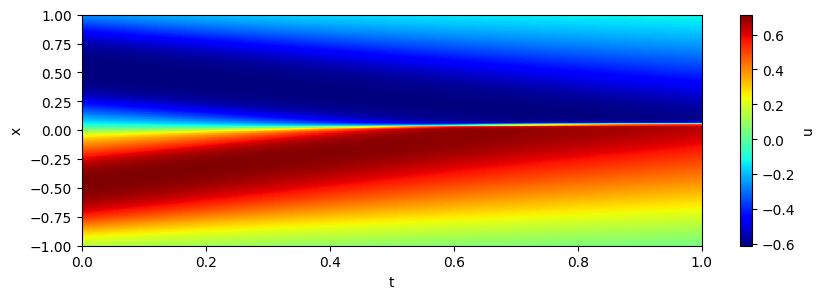

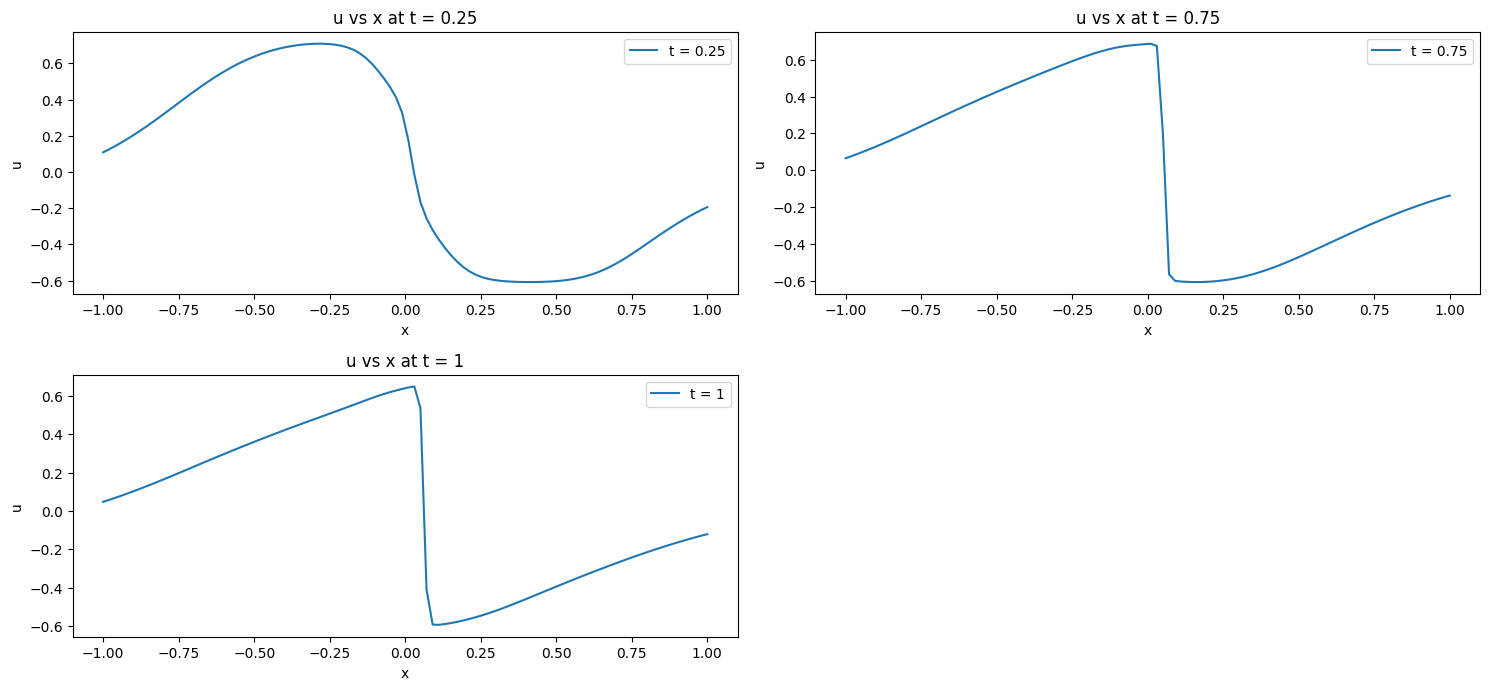

In [12]:
import matplotlib.pyplot as plt

X=np.linspace(-1,1,100)
T=np.linspace(0,1,100)
ms_t, ms_x = np.meshgrid(T , X)


## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = net(pt_t,pt_x)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_t.shape)

plt.figure(figsize=(10, 3))

# Plot the heatmap of the solution
plt.imshow(ms_u, cmap='jet', aspect='auto', origin = 'lower', extent=[0, 1, -1, 1])
plt.colorbar(label='u')
plt.xlabel('t')
plt.ylabel('x')

# Define time intervals at which you want to plot u vs x
time_intervals = [0.25, 0.75, 1]

# Plot u vs x at each time interval
plt.figure(figsize=(15, 10))
for i, t_interval in enumerate(time_intervals):
    # Find the index corresponding to the closest time value in the time array
    idx = np.abs(T - t_interval).argmin()

    # Plot u vs x at the selected time interval
    plt.subplot(3, 2, i+1)  # Adjust the subplot layout as needed
    plt.plot(X, ms_u[:, idx], label=f't = {t_interval}')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title(f'u vs x at t = {t_interval}')
    plt.legend()

plt.tight_layout()
plt.show()

